In [1]:
import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)
import pandas as pd
import lightkurve as lk
import numpy as np
import pywt
import pickle
import time
import os
import matplotlib.pyplot as plt
from context import LCWavelet
import pywt
from context import binning
from parallelbar import progress_map
from tqdm import tqdm
from functools import partial
import logging
# import gc

In [2]:
path = r'E:\Diego\Astrofisica\TFM\ExoPlanet-Detection\data3\mastDownload\Kepler'
files = os.listdir(path)
files = [f for f in files]
ds = pd.read_csv(r'E:\Diego\Astrofisica\TFM\ExoPlanet-Detection\csv\cumulative_2022.09.30_09.06.43.csv', skiprows=144)
print('Number of files:', len(files))
ds

Number of files: 9513


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,9560,10090151,K07985.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,-1.757,0.068,2.763,0.074,2.344,0.072,-1.756,0.068,2.929,0.072
9560,9561,10128825,K07986.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.497,0,...,-0.250,0.490,0.780,0.460,0.500,0.400,-0.180,0.470,0.530,0.470
9561,9562,10147276,K07987.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.021,0,...,-3.650,0.260,5.000,0.220,3.380,0.160,-3.890,0.260,5.160,0.220
9562,9563,10155286,K07988.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.092,0,...,1.320,0.670,1.690,0.530,1.450,0.110,1.370,0.660,2.000,0.460


In [3]:
count = 0
print(files)
for i, row in ds.iterrows():
    kepid = row['kepid']
    kepid = str(kepid).zfill(9)
    print('kepid:', kepid)
    dir_id = [f for f in files if kepid in f]
    print('dir_id:', dir_id)
    break

print('Number of files in the list:', count)
print('Number of files in the list:', len(files))



['kplr010797460_lc_Q011111111111111111', 'kplr009334289_lc_Q011111111111111111', 'kplr003247268_lc_Q011111011101110111', 'kplr008972058_sc_Q000333310000000000', 'kplr004918309_lc_Q011111111111111111', 'kplr009662811_lc_Q111111101110111011', 'kplr007449554_lc_Q001111111111111111', 'kplr009757613_lc_Q011111111111111111', 'kplr009757613_sc_Q000000333333333332', 'kplr008972058_lc_Q111111111111111111', 'kplr003247268_sc_Q000000000303010311', 'kplr009334289_sc_Q000000000330300032', 'kplr004918309_sc_Q000000000000010300', 'kplr011570749_lc_Q011111111111111111', 'kplr009351920_lc_Q011111111111111111', 'kplr010811496_lc_Q011111101110111011', 'kplr012602568_lc_Q011111111111111111', 'kplr011570749_sc_Q000000000000000301', 'kplr004386059_lc_Q001111011101110111', 'kplr003232859_lc_Q011111111111111111', 'kplr010848459_lc_Q011111110111011101', 'kplr002161536_lc_Q011111111111111111', 'kplr011297236_lc_Q011111111111111111', 'kplr009347899_lc_Q011111111111111111', 'kplr009941066_lc_Q011111111111111111',

In [4]:
id = 757450
first = files[200]
for f in files:
    if str(id) in f:
        first = f
        break

print('First file:', first)
kepler_files = [f for f in os.listdir(os.path.join(path, first)) if f.endswith('.fits')]
lcs = [lk.read(os.path.join(path, first, f)) for f in kepler_files]
lc_coll = lk.LightCurveCollection(lcs)
lc_ro = lc_coll.stitch()
lc_nonans = lc_ro.remove_nans()

First file: kplr000757450_lc_Q011111111111111111


In [5]:
row = ds[ds['kepid'] == 757450].iloc[0]
row

rowid                         227
kepid                      757450
kepoi_name              K00889.01
kepler_name           Kepler-75 b
koi_disposition         CONFIRMED
                         ...     
koi_dikco_mra_err           0.072
koi_dikco_mdec             -0.097
koi_dikco_mdec_err          0.078
koi_dikco_msky              0.127
koi_dikco_msky_err          0.076
Name: 226, Length: 141, dtype: object

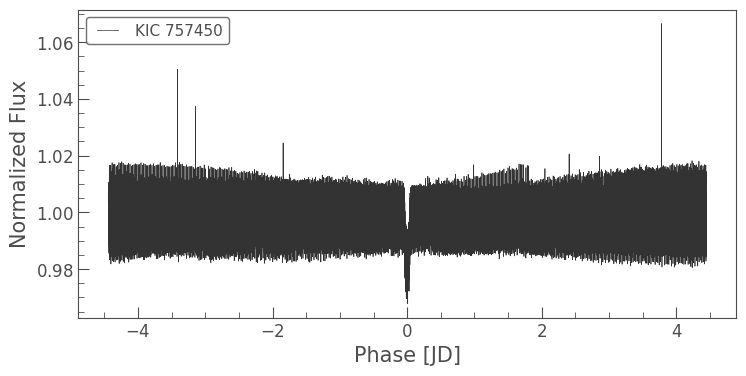

In [6]:
lc_fold = lc_nonans.fold(period=row.koi_period, epoch_time=row.koi_time0bk)
lc_fold.plot()
plt.show()

In [7]:
lc_odd = lc_fold[lc_fold.odd_mask]
lc_even = lc_fold[lc_fold.even_mask]

lc_odd.sort('time')
lc_even.sort('time')

lc_odd_global = binning.global_view(lc_odd.time.to_value('jd'), lc_odd.flux.to_value(), row.koi_period, normalize=True)
lc_even_global = binning.global_view(lc_even.time.to_value('jd'), lc_even.flux.to_value(), row.koi_period, normalize=True)
lc_odd_global = lk.lightcurve.FoldedLightCurve(time=np.arange(len(lc_odd_global)), flux=lc_odd_global)
lc_even_global = lk.lightcurve.FoldedLightCurve(time=np.arange(len(lc_even_global)), flux=lc_even_global)

lc_odd_local = binning.local_view(lc_odd.time.to_value('jd'), lc_odd.flux.to_value(), row.koi_period, row.koi_duration, normalize=True)
lc_even_local = binning.local_view(lc_even.time.to_value('jd'), lc_even.flux.to_value(), row.koi_period, row.koi_duration, normalize=True)
lc_odd_local = lk.lightcurve.FoldedLightCurve(time=np.arange(len(lc_odd_local)), flux=lc_odd_local)
lc_even_local = lk.lightcurve.FoldedLightCurve(time=np.arange(len(lc_even_local)), flux=lc_even_local)


In [8]:
levels=[1, 2, 3, 4]
wavelet_family="sym5"
cut_border_percent=0.1
wavelet_window = None
headers = {
        "period": row.koi_period,
        "koi_period_err1": row.koi_period_err1,
        "koi_period_err2": row.koi_period_err2,
        "depth": row.koi_depth,
        "depth_err1": row.koi_depth_err1,
        "depth_err2": row.koi_depth_err2,
        "duration": row.koi_duration,
        "duration_err1": row.koi_duration_err1,
        "duration_err2": row.koi_duration_err2,
        "steff": row.koi_steff,
        "steff_err1": row.koi_steff_err1,
        "steff_err2": row.koi_steff_err2,
        "impact": row.koi_impact,
        "impact_err1": row.koi_impact_err1,
        "impact_err2": row.koi_impact_err2,
        "class": row.koi_disposition,
        "wavelet_family":wavelet_family,
        "levels":levels,
        "window":wavelet_window,
        "border_cut":cut_border_percent,
        "Kepler_name":row.kepoi_name
    }
    

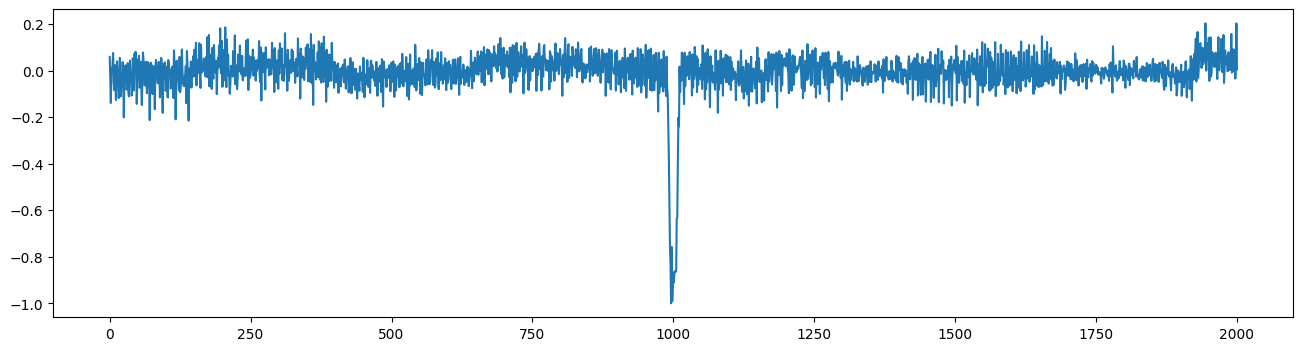

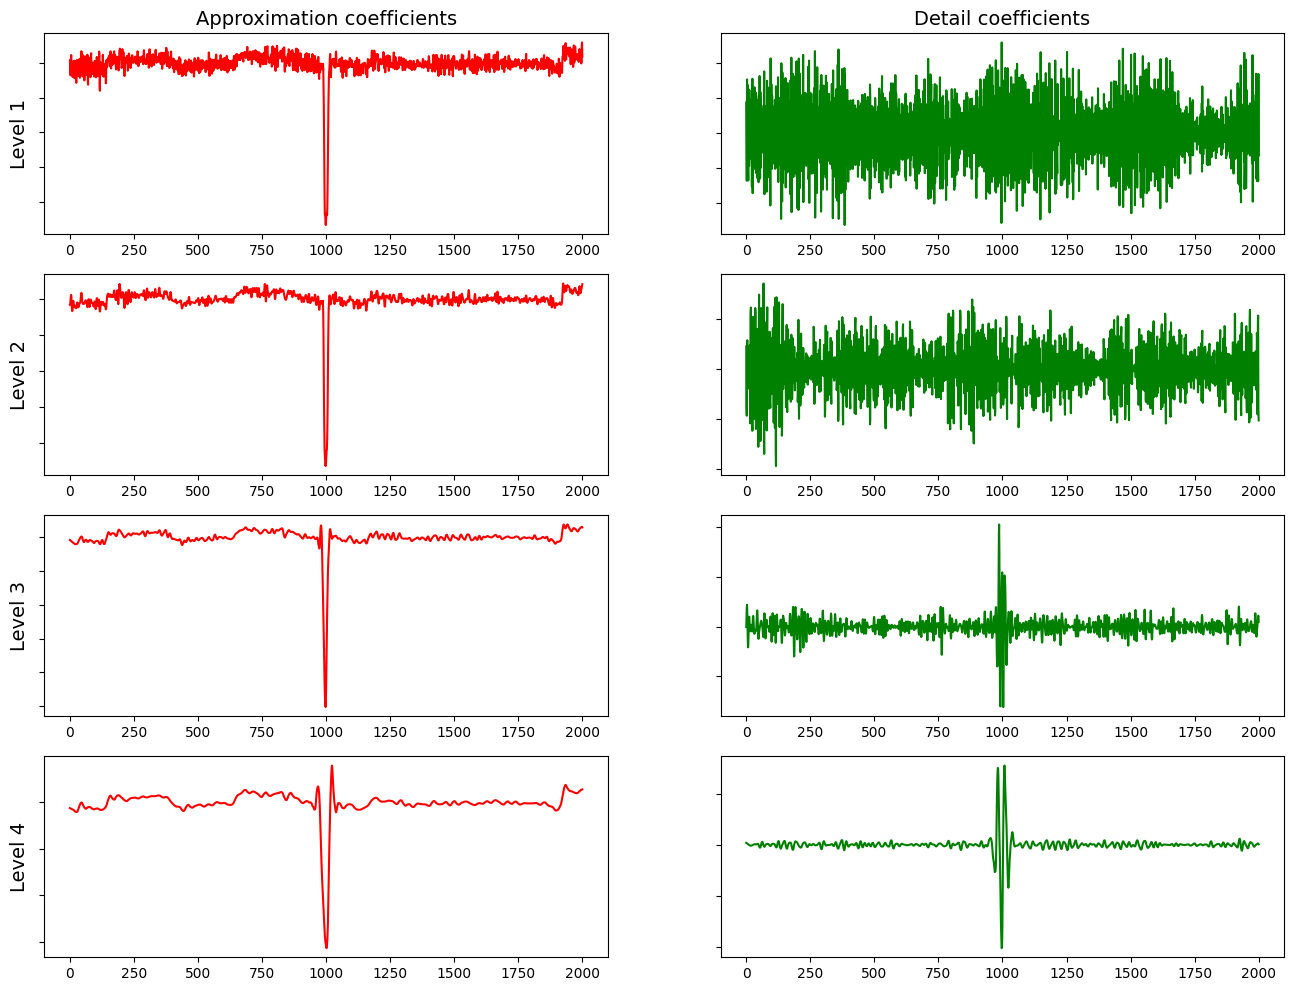

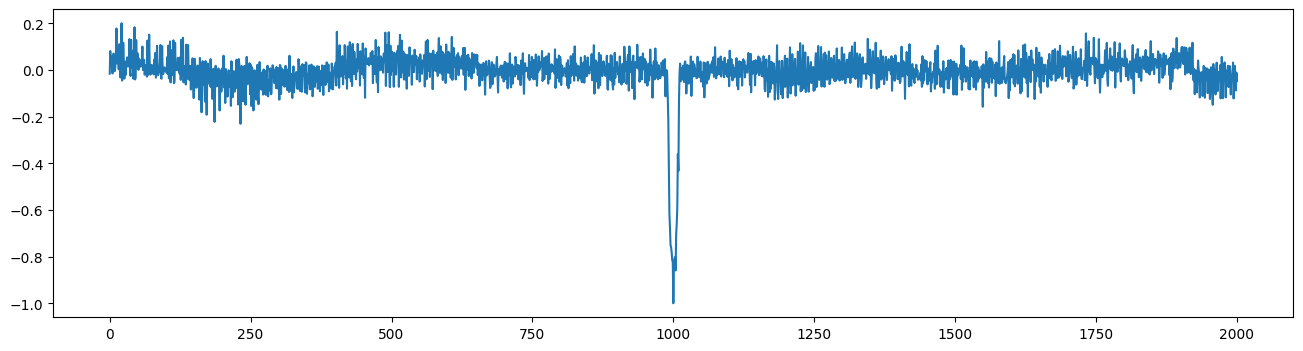

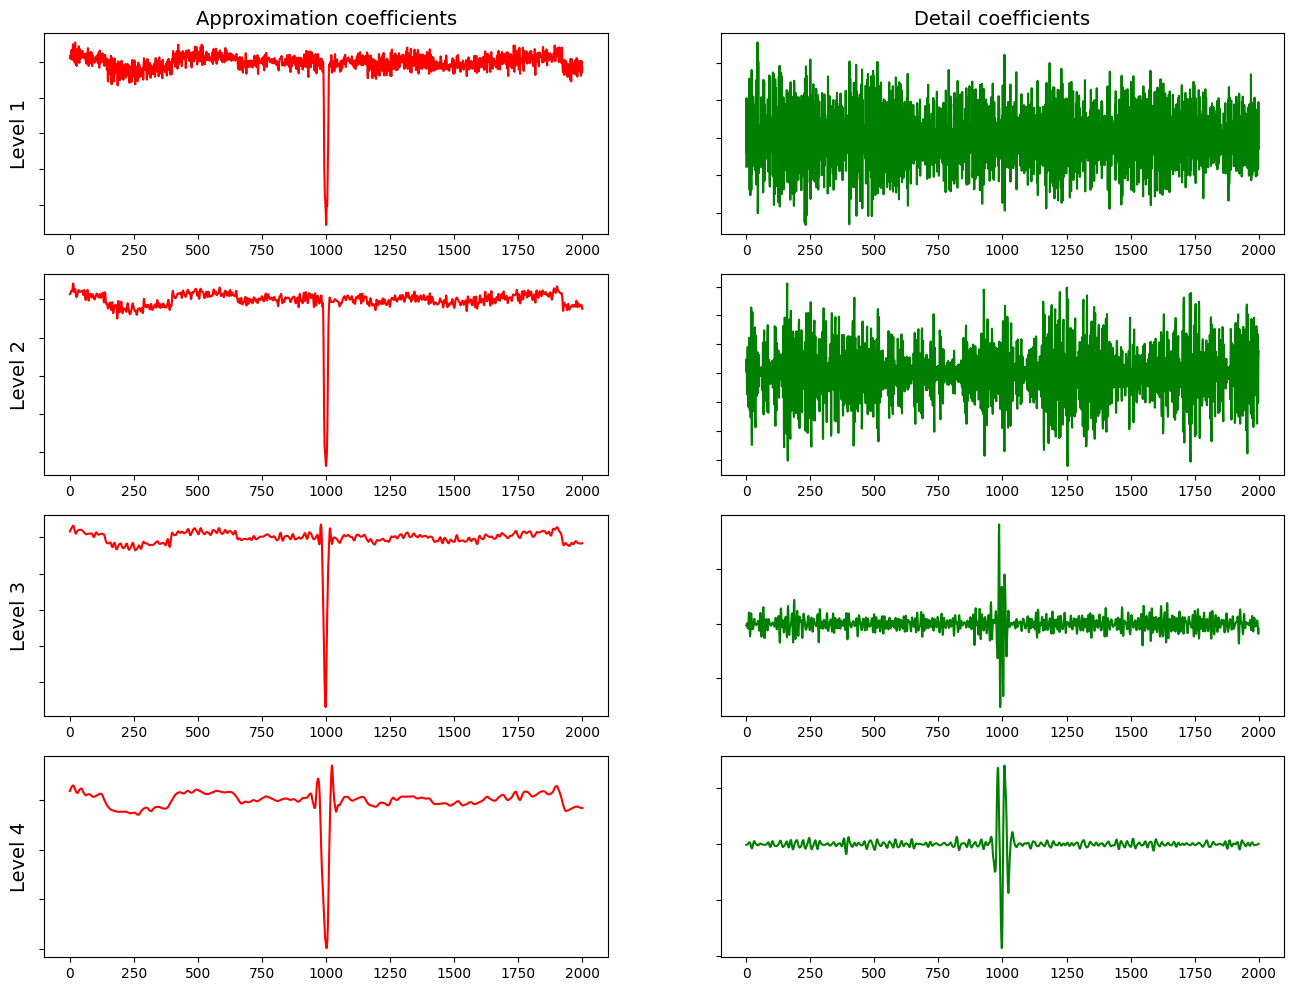

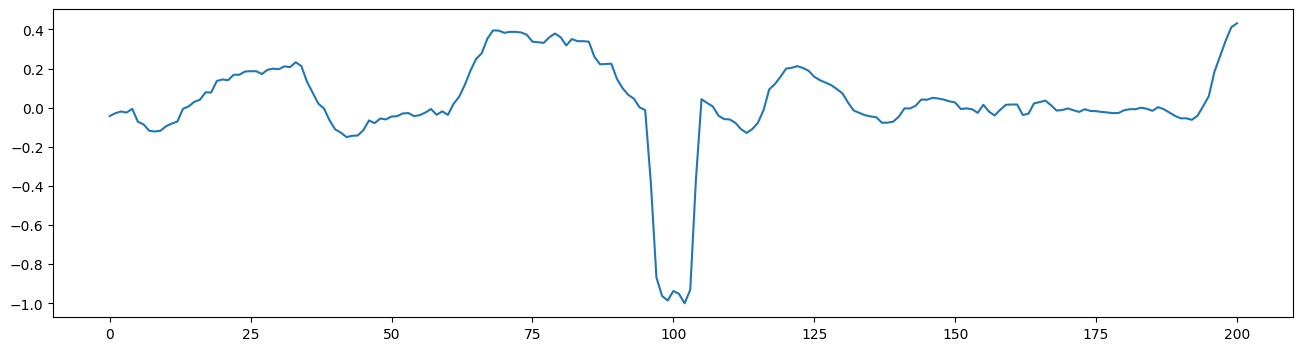

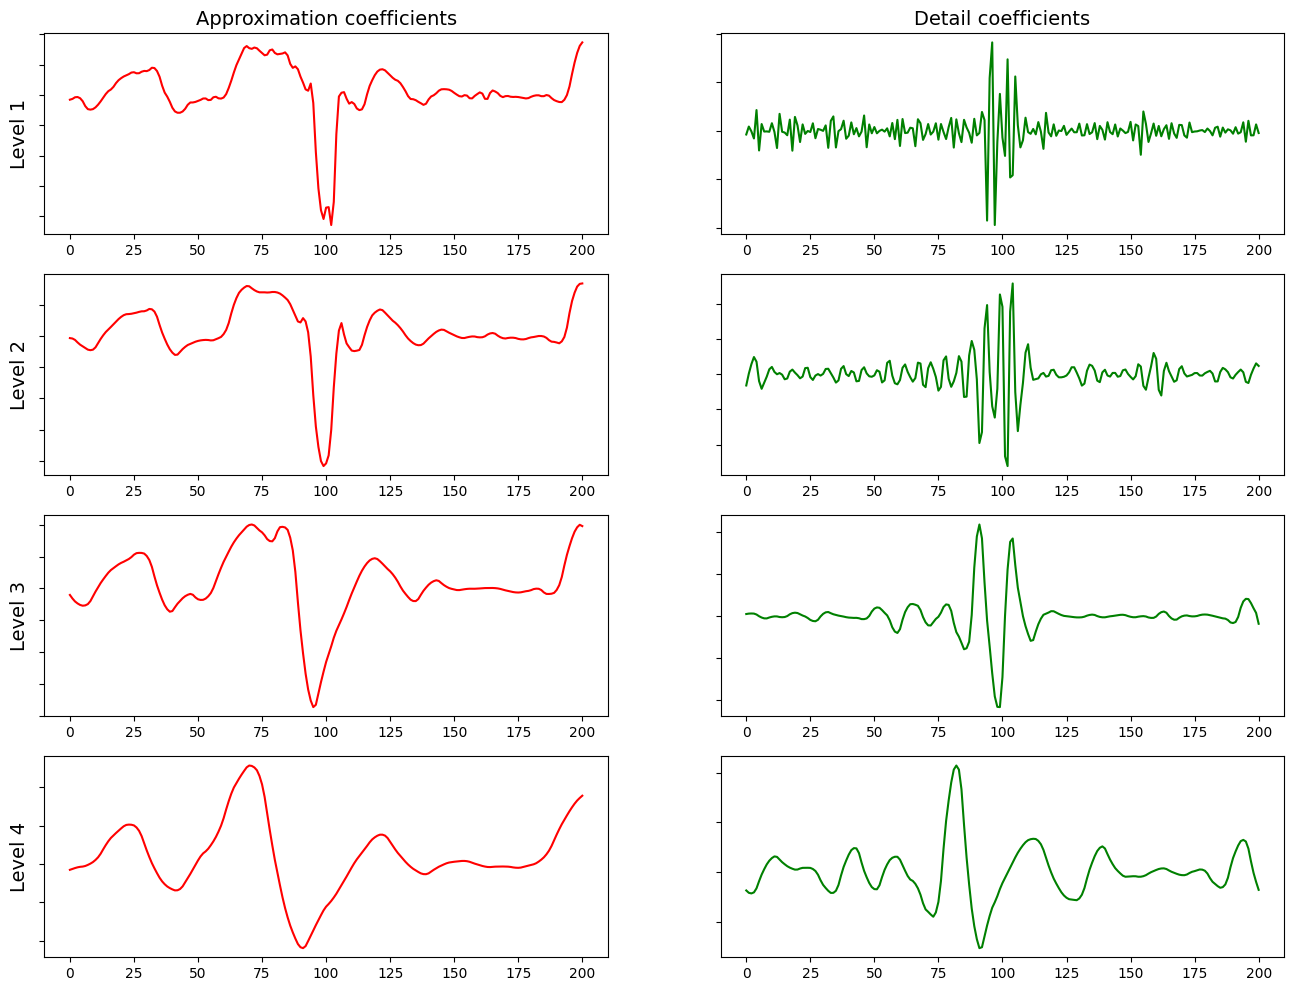

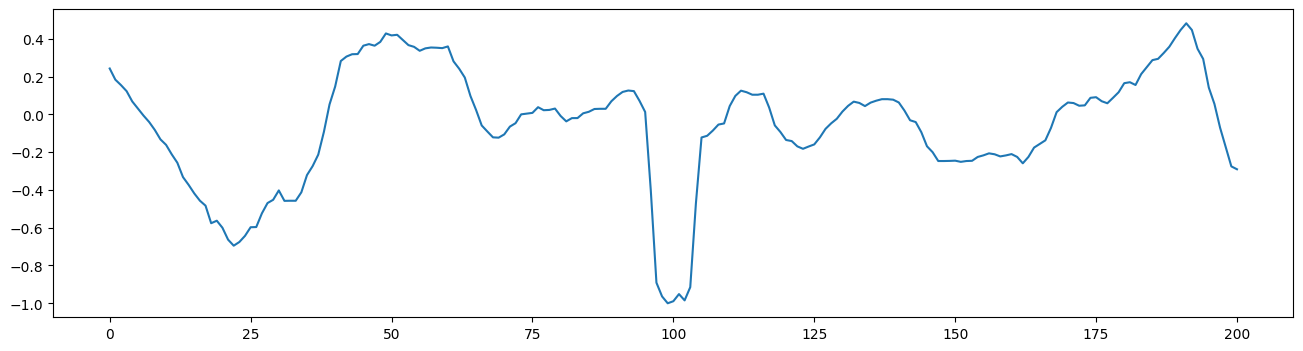

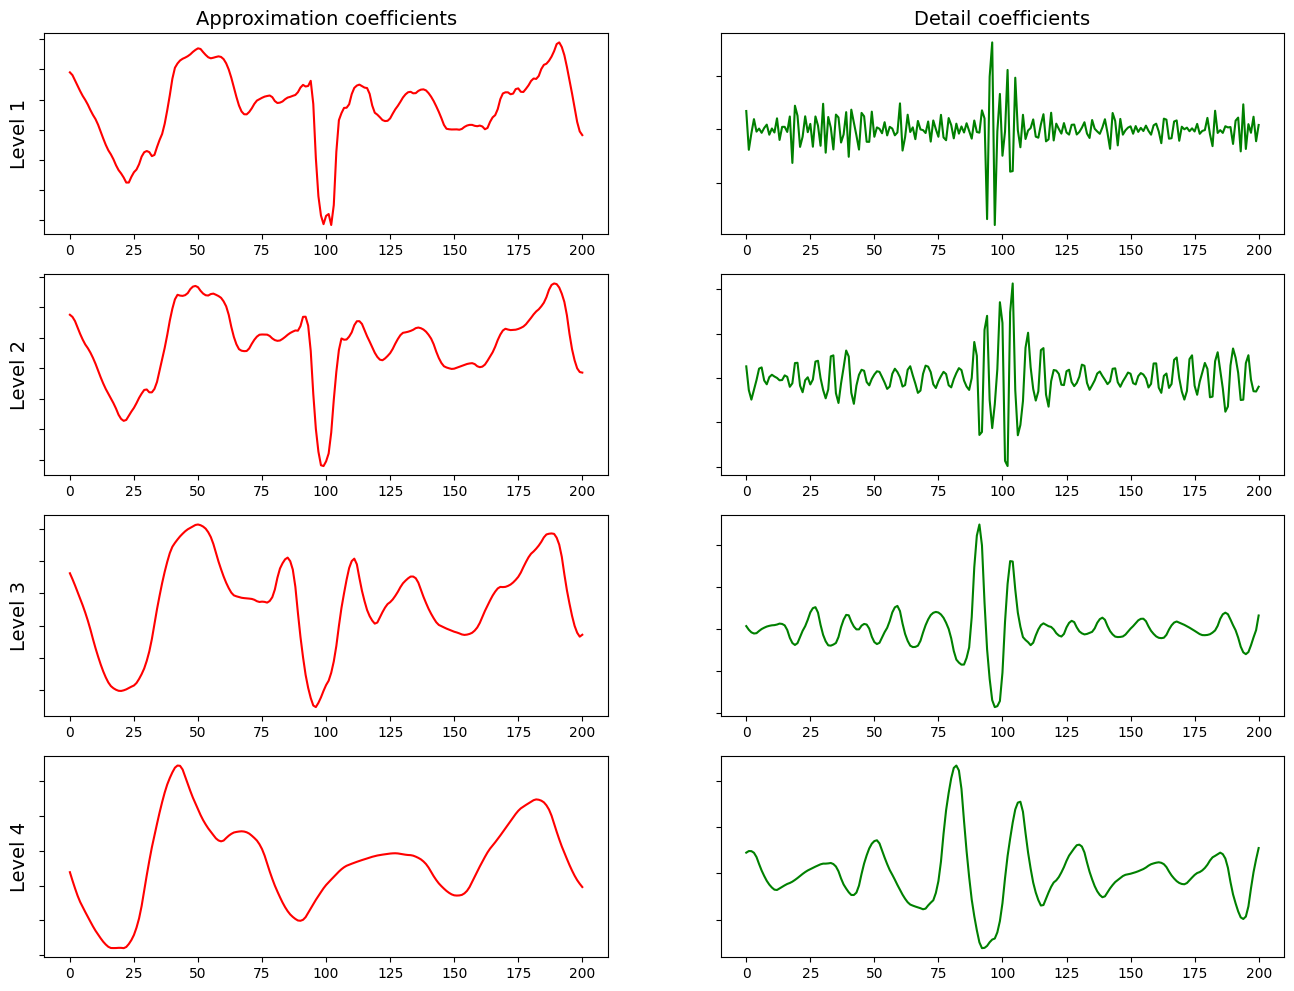

In [9]:

lc_w_even_global = LCWavelet.apply_wavelet(lc_even_global, wavelet_family, levels, cut_border_percent=cut_border_percent)
lc_w_odd_global = LCWavelet.apply_wavelet(lc_odd_global, wavelet_family, levels, cut_border_percent=cut_border_percent)

lc_w_even_local = LCWavelet.apply_wavelet(lc_even_local, wavelet_family, levels, cut_border_percent=cut_border_percent)
lc_w_odd_local = LCWavelet.apply_wavelet(lc_odd_local, wavelet_family, levels, cut_border_percent=cut_border_percent)

w_coll = LCWavelet.LightCurveWaveletGlobalLocalCollection(row.kepid, headers, lc_w_even_global, lc_w_odd_global, lc_w_even_local, lc_w_odd_local, levels)
w_coll.plot()
plt.show()

In [ ]:

data = lc_even_global.flux
wl = []
wl_sym5 = []
wl_sym5_swt = []
wl_morl = []
wl_mexh = []
wl_gaus = []
for i in range(1, 5):
    coeffs = pywt.wavedec(data, 'sym5', level=i)
    aprox = pywt.upcoef('a', coeffs[0], 'sym5', level=i, take=len(data))
    wl_sym5.append(aprox)
    # make the data even length
    if len(data) % 2 != 0:
        data = data[:-1]
    coeffs = pywt.swt(data, 'sym5', level=i, norm=True) 
    # contras: el size de los datos necesitan ser pares y no se pueden usar mexh y morl
    # pros: puedes sacar la serie normalizada
    aprox = coeffs[0][0]
    wl_sym5_swt.append(aprox)
    
    coeffs, freqs = pywt.cwt(data, scales=i, wavelet='mexh')
    aprox = coeffs[0]
    wl_mexh.append(aprox)
    coeffs, freqs = pywt.cwt(data, scales=i, wavelet='cgau1')
    aprox = coeffs[0]
    wl_gaus.append(aprox)
    coeffs, freqs = pywt.cwt(data, scales=i, wavelet='morl')
    aprox = coeffs[0]
    wl_morl.append(aprox)


# subplot of the original data and the wavelet detail
fig, axs = plt.subplots(len(wl_morl)+1, 1, figsize=(13, 10), sharex=True)
for i, coeff in enumerate(wl_gaus):
    axs[i].plot(coeff, label=f'Wavelet Coefficients (Level {i+1})')
    axs[i].legend()
    axs[i].set_ylabel('Flux')
    axs[i].set_title(f'Wavelet Coefficients (Level {i+1})')
axs[-1].plot(data, label='Original Data', color='black')
axs[-1].set_xlabel('Time')
# plt.plot(data, label='Original Data', color='black')
# for i, coeff in enumerate(wl):
#     plt.plot(coeff, label=f'Wavelet Coefficients (Level {i+1})')
plt.legend()
plt.tight_layout()
plt.gcf().set_size_inches(13, 7)
plt.show()

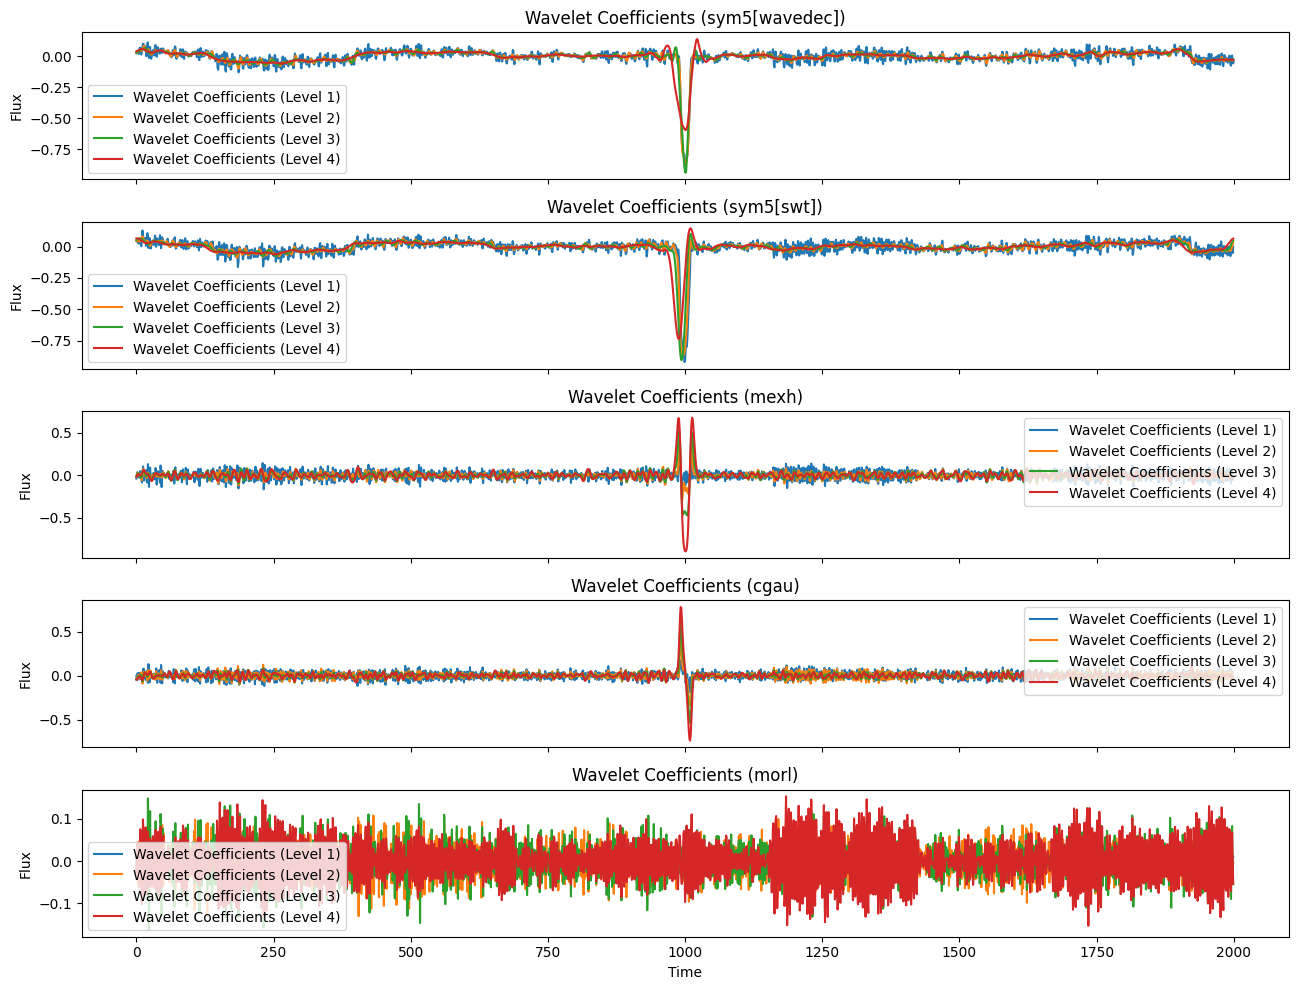

In [55]:
# plot the wavelet coefficients for each family
fig, axs = plt.subplots(5, 1, figsize=(13, 10), sharex=True)
for i, coeff in enumerate(wl_sym5):
    axs[0].plot(coeff, label=f'Wavelet Coefficients (Level {i+1})')
    axs[0].legend()
    axs[0].set_ylabel('Flux')
    axs[0].set_title('Wavelet Coefficients (sym5[wavedec])')
for i, coeff in enumerate(wl_sym5_swt):
    axs[1].plot(coeff, label=f'Wavelet Coefficients (Level {i+1})')
    axs[1].legend()
    axs[1].set_ylabel('Flux')
    axs[1].set_title('Wavelet Coefficients (sym5[swt])')

for i, coeff in enumerate(wl_mexh):
    axs[2].plot(coeff, label=f'Wavelet Coefficients (Level {i+1})')
    axs[2].legend()
    axs[2].set_ylabel('Flux')
    axs[2].set_title('Wavelet Coefficients (mexh)')

for i, coeff in enumerate(wl_gaus):
    axs[3].plot(coeff, label=f'Wavelet Coefficients (Level {i+1})')
    axs[3].legend()
    axs[3].set_ylabel('Flux')
    axs[3].set_title('Wavelet Coefficients (cgau)')

for i, coeff in enumerate(wl_morl):
    axs[4].plot(coeff, label=f'Wavelet Coefficients (Level {i+1})')
    axs[4].legend()
    axs[4].set_ylabel('Flux')
    axs[4].set_title('Wavelet Coefficients (morl)')
plt.xlabel('Time')
plt.tight_layout()
plt.gcf().set_size_inches(13, 10)
plt.show()

In [ ]:
w_coll.save(r'.')

In [ ]:
serie_path = r'.\kic_757450-K00889_01.pickle'

# Check if the file exists and is not empty
w_lc = LCWavelet.LightCurveWaveletGlobalLocalCollection.from_pickle(serie_path)

w_lc

In [ ]:
import pywt

pywt.wavelist(kind='discrete')

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',

: 